# Modelisation

After looking at the data, we can start making a simple model to evaluate the order of magnitude of the predictiveness we can expect.

We choose a **random forest** algorithm for :
* it's ability to take into account missing value (with constant imputation far from natural values),
* it's ability to use non linear relations between variables,
* it's ability for simple explanation.

Because we need to predict extreme cases, we'll go for a classification strategy.
We will go for two independant models : one to predict high risk, one to predict **at least** a mild risk.
For each model, it will be a binary classification, we will be able to use the **ROC curve** as a metric.
In this notebook, we focus only on detecting a mild risk.
The strategy will be similar for high risk but with more complications related to class unbalance.

To evaluate model performances, we will separate our trainable data (the ones with a filled feat_27) into 3 sets.
The training dataset will contain 67% of the data.
The validation and the test set will each account for 16% of the datset.
Each visit with a fille feat_27 will be randomly attributed to one of the datasets.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from context import *
from train_model import *
import visits
import shap

In [ ]:
target = 'target_mild'
df = visits.load()
df.shape

(13533, 113)


(13533, 113)

In [ ]:
from build_features import *
train, valid = get_train_valid(df, target)
len(train.columns)

remove almost emtpy 11


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


550

## Baseline model

The first model will be the most simple model possible, mainly to estimate how much information can be easily extracted from the data.
In this model, we will use age, sex and all raw features. 
Missing values are imputed with the value -99 to allow the random forest to separate by missing values.
Only features with at least 1% coverage are considered, which removes 11 features.

In [ ]:
import re
pat = re.compile(r'^feat_[0-9]{1,2}$')
train_cols = sorted(set(['is_female', 'age'] + [x for x in train.columns if pat.match(x)])
                    -set(['target_mild', 'target', 'feat_27', 'isna_27']))
len(train_cols)

30

In [ ]:
params = dict(
    n_estimators = 200,
    random_state=45,
    min_weight_fraction_leaf=5e-2,
    class_weight='balanced_subsample',
    n_jobs=-1,
)

In [ ]:
%%time
train_loss, valid_loss, conf, rf = test_rf(params, train, valid, target, train_cols)
print('train ROC', train_loss)
print('valid ROC', valid_loss)

train ROC 0.7480945047132473
valid ROC 0.6481765389082463
CPU times: user 1.5 s, sys: 375 ms, total: 1.88 s
Wall time: 824 ms


As expected from the exploration phase, it seems that there is little predicting power in those variables.
While the ROC score is still better than random, there is no clear separation between visits.
Let's look at what would these results look in term of predictions if put into production.

In the plot below, each point of the line represent a different score of risk.
For each of these score, we can evaluate how much of the actual risky patient would have been detected (in the x axis), and what proportion of patients are actually at risk among the ones who have been targetted.

Simply put, for the baseline model to detect 40% of the patients at risk, we would need to accept that 85% of the tagged patients would have no risk.

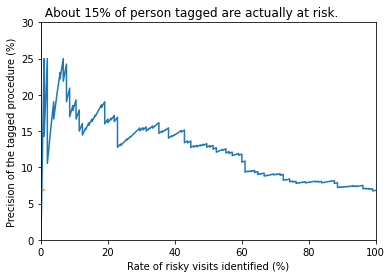

In [ ]:
from sklearn.metrics import precision_recall_curve
preds = rf.predict_proba(valid[train_cols])[:,1]
precision, recall, thresholds = precision_recall_curve(valid[target], preds)

fig, ax = plt.subplots()
ax.plot(recall*100, precision*100)
ax.plot([0, 1], [valid[target].mean()*100]*2, '-')
ax.set_xlabel('Rate of risky visits identified (%)')
ax.set_ylabel('Precision of the tagged procedure (%)')
ax.set_ylim(0, 30)
ax.set_xlim(0, 100)
ax.set_title(' About 15% of person tagged are actually at risk.', loc='left');

Now let's look at which variables bring something more.
Using the [shap](https://shap.readthedocs.io/en/latest/) technique, we will be able to identify which variables have an impact on the prediction.
In the following plot, a visit will generate a point at each line that will represent how much this variable has contributed to the risk of the visit.
The more on the right, the more this feature, for this visit contributed for a risk.
The color reprensents the value of the feature.

For the age variables, we see that blue values are on the left, while red dots are on the right.
Blue dots concern young patients.
Because they are on the left it means that the young age of these patients contributed to a lower risk.
On the opposite, the high age of the patients on the right contributed to an elevated risk.
This is coherent with our observations in the exploration phase.

For the unnamed features, blue dots most likely represents the -99 value, representing missing values.
For feat_15, which is at roughly a 15% filling rate, it shows that not having this variable filled is actually a small indication of safety.
Having this value filled can have either a positive or negative impact.
The coloration does not allow to have a precise understanding.

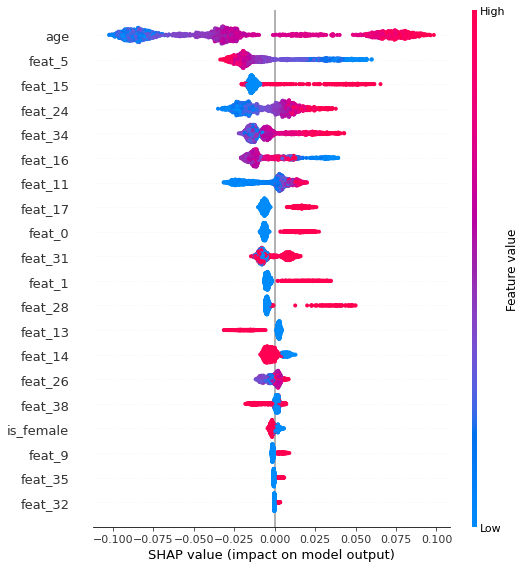

CPU times: user 1.61 s, sys: 469 ms, total: 2.08 s
Wall time: 1.37 s


In [ ]:
%%time
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(valid[train_cols])
shap.summary_plot(shap_values[1], valid[train_cols])

## Filled Model

In the baseline model, it was decided to make a simple imputation of the missing values and let the random forest deal with them.
Here we will propose a different strategy.
We will use a KNNImputer technique in order to fill the missing values of feat_* variables.
In order to keep the information from missing values, we will add binary variables which tag missing values.

In [ ]:
train_cols = list(filter(lambda s : s.startswith('imp_') 
                         or (s.startswith('isna') and len(s)<8), 
                         train.columns)) + ['age', 'is_female']
len(train_cols)

55

In [ ]:
params = dict(
    n_estimators = 200,
    random_state=45,
    min_weight_fraction_leaf=5e-2,
    class_weight='balanced_subsample',
    n_jobs=-1,
)

In [ ]:
%%time
from train_model import *
train_loss, valid_loss, conf, rf = test_rf(params, train, valid, target, train_cols)
print('train ROC', train_loss)
print('valid ROC', valid_loss)

train ROC 0.7830573722523462
valid ROC 0.6472872075659531
CPU times: user 3.17 s, sys: 297 ms, total: 3.47 s
Wall time: 1.07 s


This model shows an increase of the train metrics but no generalisation of this performance gain.

## Undersampled model 

We deal here with a problem of unbalanced classification.
There is about 15 times more patients not at risk than patients at risk.
With such an imbalance, the random forest may have difficulty separating the two categories.
In this iteration, we propose to remove 80% of the negative instances in the **training** dataset to give more emphasis on the patients at risk during training.
To fairly estimate the changes in performances, this removal must **not** be done on the validation set.

In [ ]:
import re
pat = re.compile(r'^feat_[0-9]{1,2}$')
train_cols = sorted(set(['is_female', 'age'] + [x for x in train.columns if pat.match(x)])
                    -set(['target_mild', 'target', 'feat_27', 'isna_27']))
len(train_cols)

30

In [ ]:
params = dict(
    n_estimators = 200,
    random_state=45,
    min_weight_fraction_leaf=5e-2,
    class_weight='balanced_subsample',
    n_jobs=-1,
)

In [ ]:
np.random.seed(56)
chosen = np.random.binomial(1, 0.2, size=len(train))
tmp = train[(chosen==1)|(train[target]==1)]
train.shape, tmp.shape, tmp[target].mean()

((6158, 550), (1579, 550), 0.2640911969601013)

In [ ]:
%%time
train_loss, valid_loss, conf, rf = test_rf(params, tmp, valid, target, train_cols)
print('train ROC', train_loss)
print('valid ROC', valid_loss)

train ROC 0.7622163886790738
valid ROC 0.6476190476190476
CPU times: user 844 ms, sys: 359 ms, total: 1.2 s
Wall time: 716 ms


It seems that class unbalance is not a significatif concern in this classification problem.

## Interaction Model

Once we have set our baseline, we can look at ways to better exploit our data.
While in theory, random forest is able to take interaction into account, in practive it is always a better solution to provide it with meaningfull features.

For this reason, we will add new features in the model.
We will make the product of each variable with each other.
In practice, it will allow to separate variables values, depending on other variables values.

In [ ]:
train_cols = list(filter(lambda s : s.startswith('feat') or s.startswith('age'), train.columns))
len(train_cols)

464

In [ ]:
params = dict(
    n_estimators = 2000,
    random_state=45,
    min_weight_fraction_leaf=5e-2,
    class_weight='balanced_subsample',
    max_features = 0.1,
    n_jobs=-1,
)

In [ ]:
%%time
train_loss, valid_loss, conf, rf = test_rf(params, train, valid, target, train_cols)
print('train ROC', train_loss)
print('valid ROC', valid_loss)

train ROC 0.7791450866479783
valid ROC 0.6461523145843704
CPU times: user 2min 9s, sys: 2.48 s, total: 2min 12s
Wall time: 20.8 s


Text(0.0, 1.0, ' About 15% of person tagged are actually at risk.')

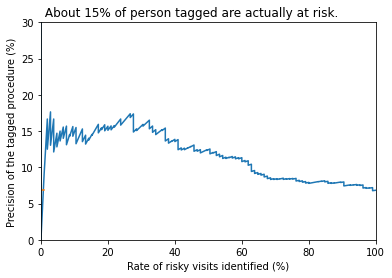

In [ ]:
from sklearn.metrics import precision_recall_curve
preds = rf.predict_proba(valid[train_cols])[:,1]
precision, recall, thresholds = precision_recall_curve(valid[target], preds)

fig, ax = plt.subplots()
ax.plot(recall*100, precision*100)
ax.plot([0, 1], [valid[target].mean()*100]*2, '-')
ax.set_xlabel('Rate of risky visits identified (%)')
ax.set_ylabel('Precision of the tagged procedure (%)')
ax.set_ylim(0, 30)
ax.set_xlim(0, 100)
ax.set_title(' About 15% of person tagged are actually at risk.', loc='left')

We this model we did not change the performance on both metrics.
We actually sligthly degraded the performance, but could be brought back to normal with a selection of the most predictive variables.

If we look at the explainability plot, we observe that the new variables are actually the more predictive.
Indeed we helped the random forest in extracting the info but it was already capable of finding it.

We also see that the best variables are combinations of age with other variables.
The blue most likely represent a missing feature with an old patient, while the red represents an interaction between the age and the value of the metric for this patient.

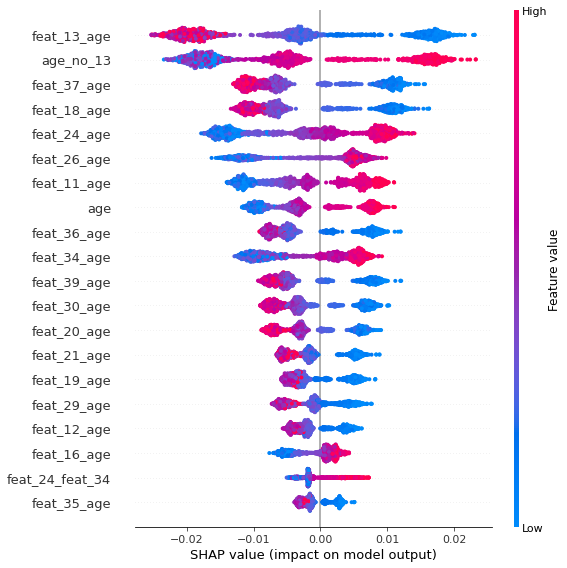

CPU times: user 7.19 s, sys: 406 ms, total: 7.59 s
Wall time: 6.87 s


In [ ]:
%%time
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(valid[train_cols])
shap.summary_plot(shap_values[1], valid[train_cols])

## Missing pattern model

In this model, we leverage the work done in the notebook 2_a_Encoding_missing_values, which has found a way to encode the information of the missingness of values in all feat variables.
We still use the variables from the baseline model, but we add 5 variables related to the pattern of missing value of each instance.
These variables are :
* the 2 coordinates of the instance in this embedding,
* the label of the embedding cluster the instance belong to,
* 2 target encodings of the categorical label.

The results show a slight improvement of performances.
When looking at variable, importance, those new variables appear only at the 14 position.
They are not strong indicators of the risk of hear infection.

In [ ]:
pat = re.compile(r'^feat_[0-9]{1,2}$')
train_cols = sorted(set(['is_female', 'age'] + [x for x in train.columns if pat.match(x) or x.startswith('pipe')])
                    -set(['target_mild', 'target', 'feat_27', 'isna_27']))

len(train_cols)

35

In [ ]:
params = dict(
    n_estimators = 200,
    random_state=45,
    min_weight_fraction_leaf=5e-2,
    class_weight='balanced_subsample',
    n_jobs=-1,
)

In [ ]:
%%time
train_loss, valid_loss, conf, rf = test_rf(params, train, valid, target, train_cols)
print('train ROC', train_loss)
print('valid ROC', valid_loss)

train ROC 0.7543672778203148
valid ROC 0.6424423427907748
CPU times: user 2 s, sys: 531 ms, total: 2.53 s
Wall time: 1.08 s


Text(0.0, 1.0, ' About 15% of person tagged are actually at risk.')

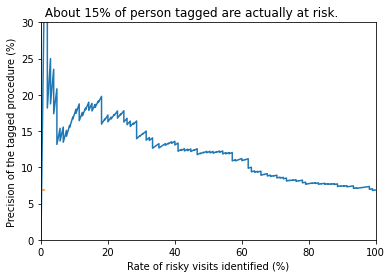

In [ ]:
from sklearn.metrics import precision_recall_curve
preds = rf.predict_proba(valid[train_cols])[:,1]
precision, recall, thresholds = precision_recall_curve(valid[target], preds)

fig, ax = plt.subplots()
ax.plot(recall*100, precision*100)
ax.plot([0, 1], [valid[target].mean()*100]*2, '-')
ax.set_xlabel('Rate of risky visits identified (%)')
ax.set_ylabel('Precision of the tagged procedure (%)')
ax.set_ylim(0, 30)
ax.set_xlim(0, 100)
ax.set_title(' About 15% of person tagged are actually at risk.', loc='left')

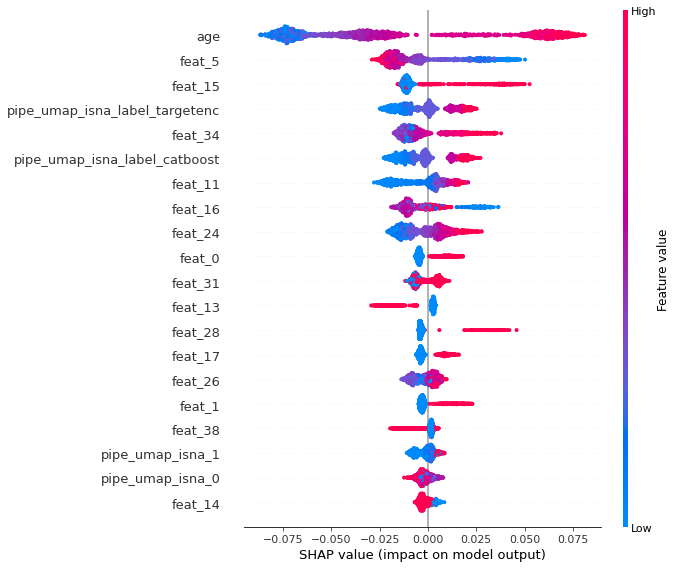

CPU times: user 2.16 s, sys: 312 ms, total: 2.47 s
Wall time: 1.72 s


In [ ]:
%%time
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(valid[train_cols])
shap.summary_plot(shap_values[1], valid[train_cols])

## Conclusion

From a baseline model, we have implemented multiple variations in order to try to better present the data to the random forest.
* We have tried to tackle class imbalance with an undersampling technique
* We have tried to tackle missing values by different imputation method.

Finally, the baseline model remains the most performant and, more importantly, the most explainable model.

We reach a performance of 65% on the ROC metric.